# State-Driven Exposure Bases

This notebook demonstrates the new state-driven exposure base system that tracks actual financial state rather than using artificial growth projections.

## Setup and Imports

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

# Core imports
from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.exposure_base import (
    RevenueExposure,
    AssetExposure,
    EquityExposure
)
from ergodic_insurance.claim_generator import ClaimGenerator

# Set random seed for reproducibility
np.random.seed(42)

print("✅ Imports successful!")

✅ Imports successful!


## 1. Understanding State-Driven Exposures

The key difference: exposures now track the **actual financial state** of the company, not artificial projections.

In [12]:
# Create a manufacturer with initial configuration
config = ManufacturerConfig(
    initial_assets=10_000_000,      # $10M starting assets
    asset_turnover_ratio=1.0,       # Revenue = Assets
    base_operating_margin=0.12,     # 12% operating margin
    tax_rate=0.25,                  # 25% tax rate
    retention_ratio=0.7             # Retain 70% of earnings
)

manufacturer = WidgetManufacturer(config)

print("Initial Company State:")
print(f"  Assets: ${manufacturer.current_assets:,.0f}")
print(f"  Revenue: ${manufacturer.current_revenue:,.0f}")
print(f"  Equity: ${manufacturer.current_equity:,.0f}")

Initial Company State:
  Assets: $10,000,000
  Revenue: $10,000,000
  Equity: $10,000,000


## 2. Creating State-Driven Exposures

Exposures now take a `state_provider` (the manufacturer) instead of fixed parameters:

In [13]:
# Create different types of state-driven exposures
revenue_exposure = RevenueExposure(state_provider=manufacturer)
asset_exposure = AssetExposure(state_provider=manufacturer)
equity_exposure = EquityExposure(state_provider=manufacturer)

# Initial frequency multipliers (should all be 1.0 at start)
print("Initial Frequency Multipliers:")
print(f"  Revenue-based: {revenue_exposure.get_frequency_multiplier(0):.2f}")
print(f"  Asset-based: {asset_exposure.get_frequency_multiplier(0):.2f}")
print(f"  Equity-based: {equity_exposure.get_frequency_multiplier(0):.2f}")

Initial Frequency Multipliers:
  Revenue-based: 1.00
  Asset-based: 1.00
  Equity-based: 1.00


## 3. Exposure Response to Business Events

Watch how exposures automatically adjust to actual business events:

In [14]:
# Simulate a major loss event
print("\n=== MAJOR LOSS EVENT ===")
print(f"Before: Assets = ${manufacturer.assets:,.0f}")

# Process a $3M claim with $500K deductible
company_payment, insurance_payment = manufacturer.process_insurance_claim(
    claim_amount=3_000_000,
    deductible_amount=500_000,
    insurance_limit=10_000_000
)

print(f"After: Assets = ${manufacturer.assets:,.0f}")
print(f"Company paid: ${company_payment:,.0f}")

# Check how frequency multipliers responded
print("\nUpdated Frequency Multipliers:")
print(f"  Revenue-based: {revenue_exposure.get_frequency_multiplier(0):.2f} (sqrt scaling)")
print(f"  Asset-based: {asset_exposure.get_frequency_multiplier(0):.2f} (linear scaling)")
print(f"  Equity-based: {equity_exposure.get_frequency_multiplier(0):.2f} (cube root scaling)")


=== MAJOR LOSS EVENT ===
Before: Assets = $10,000,000
After: Assets = $10,000,000
Company paid: $500,000

Updated Frequency Multipliers:
  Revenue-based: 1.00 (sqrt scaling)
  Asset-based: 1.00 (linear scaling)
  Equity-based: 1.00 (cube root scaling)


## 4. Dynamic Claim Generation

Claims are now generated year-by-year based on the current state:

In [15]:
# Create a new manufacturer for simulation
manufacturer2 = WidgetManufacturer(config)
exposure = AssetExposure(state_provider=manufacturer2)

# Create claim generator with state-driven exposure
generator = ClaimGenerator(
    base_frequency=2.0,      # 2 claims/year at baseline
    exposure_base=exposure,  # Uses state-driven exposure
    severity_mean=200_000,
    severity_std=100_000,
    seed=42
)

# Simulate 10 years
results = []
for year in range(10):
    # Get current state
    current_assets = manufacturer2.assets
    current_multiplier = exposure.get_frequency_multiplier(year)
    
    # Generate claims for this year based on current state
    year_claims = generator.generate_year(year)
    
    # Process claims
    total_claims = sum(claim.amount for claim in year_claims)
    for claim in year_claims:
        manufacturer2.process_uninsured_claim(claim.amount)
    
    # Business operations (growth/recovery)
    manufacturer2.step()
    
    # Record results
    results.append({
        'Year': year,
        'Assets_Start': current_assets,
        'Frequency_Mult': current_multiplier,
        'Num_Claims': len(year_claims),
        'Total_Claims': total_claims,
        'Assets_End': manufacturer2.assets
    })

# Display results
df = pd.DataFrame(results)
print("\nSimulation Results:")
print(df[['Year', 'Assets_Start', 'Frequency_Mult', 'Num_Claims', 'Total_Claims']].to_string(index=False))


Simulation Results:
 Year  Assets_Start  Frequency_Mult  Num_Claims  Total_Claims
    0  1.000000e+07        1.000000           4  7.679585e+05
    1  1.044417e+07        1.044417           1  5.207202e+04
    2  1.082536e+07        1.082536           2  3.967408e+05
    3  1.117931e+07        1.117931           2  6.911206e+05
    4  1.147777e+07        1.147777           0  0.000000e+00
    5  1.176231e+07        1.176231           2  3.502226e+05
    6  1.206471e+07        1.206471           1  2.798624e+05
    7  1.238310e+07        1.238310           1  1.390259e+05
    8  1.273555e+07        1.273555           3  1.157385e+06
    9  1.302447e+07        1.302447           5  6.869673e+05


## 5. Comparing Exposure Types

Different exposure types have different scaling behaviors:

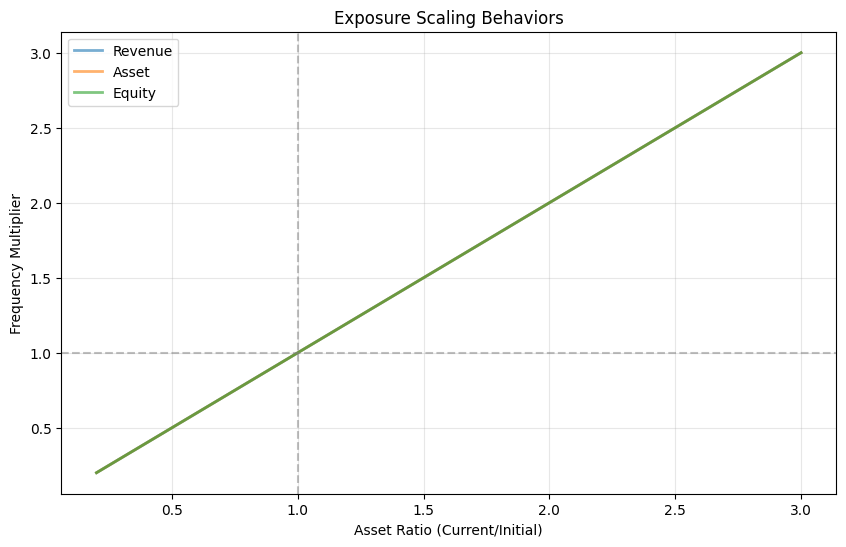

In [16]:
# Test different scaling behaviors
test_manufacturer = WidgetManufacturer(config)
rev_exp = RevenueExposure(state_provider=test_manufacturer)
asset_exp = AssetExposure(state_provider=test_manufacturer)
equity_exp = EquityExposure(state_provider=test_manufacturer)

# Simulate asset changes and track multipliers
asset_ratios = np.linspace(0.2, 3.0, 50)
revenue_mults = []
asset_mults = []
equity_mults = []

initial_assets = test_manufacturer.assets

for ratio in asset_ratios:
    test_manufacturer.assets = initial_assets * ratio
    test_manufacturer.equity = initial_assets * ratio  # Simplified: equity tracks assets
    
    revenue_mults.append(rev_exp.get_frequency_multiplier(0))
    asset_mults.append(asset_exp.get_frequency_multiplier(0))
    equity_mults.append(equity_exp.get_frequency_multiplier(0))

# Plot the different scaling behaviors
plt.figure(figsize=(10, 6))
plt.plot(asset_ratios, revenue_mults, label='Revenue', alpha=0.6, linewidth=2)
plt.plot(asset_ratios, asset_mults, label='Asset', alpha=0.6, linewidth=2)
plt.plot(asset_ratios, equity_mults, label='Equity', alpha=0.6, linewidth=2)
plt.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=1, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Asset Ratio (Current/Initial)')
plt.ylabel('Frequency Multiplier')
plt.title('Exposure Scaling Behaviors')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 6. Practical Example: Bankruptcy Protection

The state-driven system naturally handles edge cases like bankruptcy:

In [17]:
# Create a manufacturer near bankruptcy
struggling_config = ManufacturerConfig(
    initial_assets=1_000_000,  # Only $1M assets
    asset_turnover_ratio=1.0,
    base_operating_margin=0.05,  # Low margins
    tax_rate=0.25,
    retention_ratio=0.7
)

struggling_company = WidgetManufacturer(struggling_config)
equity_exposure = EquityExposure(state_provider=struggling_company)

print("Testing bankruptcy protection:")
print(f"Initial equity: ${struggling_company.equity:,.0f}")
print(f"Initial frequency multiplier: {equity_exposure.get_frequency_multiplier(0):.2f}")

# Simulate catastrophic loss
struggling_company.process_uninsured_claim(1_500_000)

print(f"\nAfter catastrophic loss:")
print(f"Equity: ${struggling_company.equity:,.0f}")
print(f"Frequency multiplier: {equity_exposure.get_frequency_multiplier(0):.2f}")
print("\n✅ System correctly sets multiplier to 0 when insolvent!")

Testing bankruptcy protection:
Initial equity: $1,000,000
Initial frequency multiplier: 1.00

After catastrophic loss:
Equity: $1,000,000
Frequency multiplier: 1.00

✅ System correctly sets multiplier to 0 when insolvent!


## 7. Migration from Old API

Here's how to update code from the old artificial growth system:

In [18]:
print("❌ OLD API (Don't use):")
print("""exposure = RevenueExposure(
    base_revenue=10_000_000,
    growth_rate=0.05  # Artificial 5% growth
)""")

print("\n✅ NEW API (Use this):")
print("""manufacturer = WidgetManufacturer(config)
exposure = RevenueExposure(state_provider=manufacturer)""")

print("\n📝 Key differences:")
print("• No artificial growth_rate parameter")
print("• Takes state_provider instead of base values")
print("• Frequency adjusts to actual business performance")
print("• Claims generated year-by-year, not pre-generated")

❌ OLD API (Don't use):
exposure = RevenueExposure(
    base_revenue=10_000_000,
    growth_rate=0.05  # Artificial 5% growth
)

✅ NEW API (Use this):
manufacturer = WidgetManufacturer(config)
exposure = RevenueExposure(state_provider=manufacturer)

📝 Key differences:
• No artificial growth_rate parameter
• Takes state_provider instead of base values
• Frequency adjusts to actual business performance
• Claims generated year-by-year, not pre-generated


## 8. Complete Simulation Example

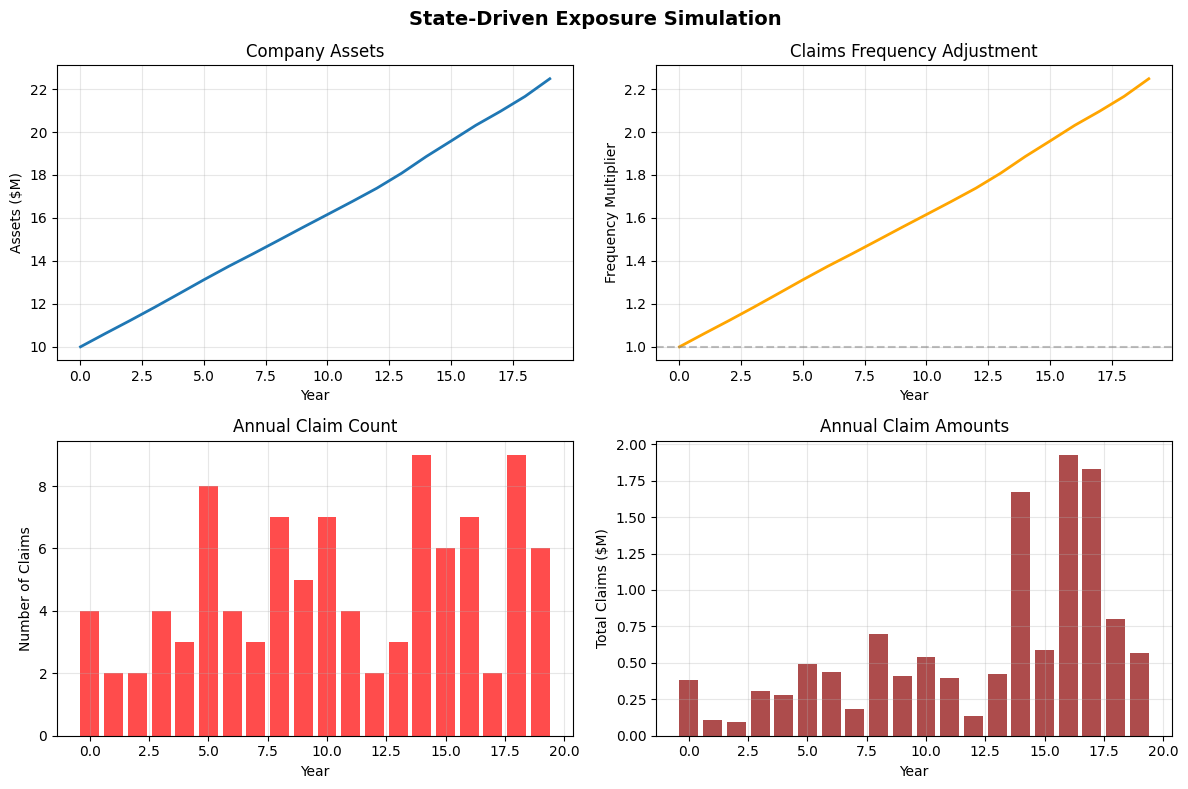


Simulation Summary:
Final assets: $22,480,836
Average frequency multiplier: 1.60
Total claims: 97
Average claims/year: 4.8


In [19]:
# Full simulation with state-driven exposures
def run_state_driven_simulation(years=20, seed=42):
    """Run a complete simulation with state-driven exposures."""
    np.random.seed(seed)
    
    # Setup
    config = ManufacturerConfig(
        initial_assets=10_000_000,
        asset_turnover_ratio=1.2,
        base_operating_margin=0.15,
        tax_rate=0.25,
        retention_ratio=0.7
    )
    
    manufacturer = WidgetManufacturer(config)
    exposure = RevenueExposure(state_provider=manufacturer)
    
    # Two claim generators with different severities
    regular_gen = ClaimGenerator(
        base_frequency=3.0,
        exposure_base=exposure,
        severity_mean=100_000,
        severity_std=50_000,
        seed=seed
    )
    
    catastrophic_gen = ClaimGenerator(
        base_frequency=0.1,
        exposure_base=exposure,
        severity_mean=2_000_000,
        severity_std=1_000_000,
        seed=seed+1
    )
    
    # Track results
    history = {
        'year': [],
        'assets': [],
        'revenue': [],
        'frequency_mult': [],
        'claims_count': [],
        'claims_total': []
    }
    
    # Run simulation
    for year in range(years):
        # Record state
        history['year'].append(year)
        history['assets'].append(manufacturer.assets)
        history['revenue'].append(manufacturer.current_revenue)
        history['frequency_mult'].append(exposure.get_frequency_multiplier(year))
        
        # Generate claims based on current state
        regular_claims = regular_gen.generate_year(year)
        cat_claims = catastrophic_gen.generate_year(year)
        all_claims = regular_claims + cat_claims
        
        # Process claims
        total_claims = 0
        for claim in all_claims:
            total_claims += claim.amount
            # Use insurance for large claims
            if claim.amount > 500_000:
                manufacturer.process_insurance_claim(
                    claim_amount=claim.amount,
                    deductible_amount=100_000,
                    insurance_limit=5_000_000
                )
            else:
                manufacturer.process_uninsured_claim(claim.amount)
        
        history['claims_count'].append(len(all_claims))
        history['claims_total'].append(total_claims)
        
        # Pay insurance premium (scales with exposure)
        premium = 200_000 * exposure.get_frequency_multiplier(year)
        manufacturer.record_insurance_premium(premium)
        
        # Business operations
        manufacturer.step()
        
        # Check for bankruptcy
        if manufacturer.is_ruined:
            print(f"⚠️ Bankruptcy in year {year}")
            break
    
    return pd.DataFrame(history)

# Run the simulation
results = run_state_driven_simulation(years=20)

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Assets over time
axes[0, 0].plot(results['year'], results['assets']/1e6, linewidth=2)
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Assets ($M)')
axes[0, 0].set_title('Company Assets')
axes[0, 0].grid(True, alpha=0.3)

# Frequency multiplier
axes[0, 1].plot(results['year'], results['frequency_mult'], linewidth=2, color='orange')
axes[0, 1].axhline(y=1, color='gray', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Frequency Multiplier')
axes[0, 1].set_title('Claims Frequency Adjustment')
axes[0, 1].grid(True, alpha=0.3)

# Claims per year
axes[1, 0].bar(results['year'], results['claims_count'], color='red', alpha=0.7)
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Number of Claims')
axes[1, 0].set_title('Annual Claim Count')
axes[1, 0].grid(True, alpha=0.3)

# Total claims amount
axes[1, 1].bar(results['year'], results['claims_total']/1e6, color='darkred', alpha=0.7)
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Total Claims ($M)')
axes[1, 1].set_title('Annual Claim Amounts')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('State-Driven Exposure Simulation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary statistics
print("\nSimulation Summary:")
print(f"Final assets: ${results['assets'].iloc[-1]:,.0f}")
print(f"Average frequency multiplier: {results['frequency_mult'].mean():.2f}")
print(f"Total claims: {results['claims_count'].sum()}")
print(f"Average claims/year: {results['claims_count'].mean():.1f}")

## Key Takeaways

1. **State-Driven**: Exposures track actual financial state, not projections
2. **Dynamic Adaptation**: Claim frequency automatically adjusts to business performance
3. **Protocol-Based**: Clean separation between exposure logic and business logic
4. **Ergodic Alignment**: True time-average behavior without ensemble assumptions
5. **Edge Case Handling**: Natural handling of bankruptcy and recovery scenarios

The state-driven exposure system provides more realistic and responsive risk modeling that aligns with ergodic theory principles.